<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/heatonresearch_gan_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Jeff Heaton](https://raw.githubusercontent.com/jeffheaton/present/master/images/github.jpg)

Copyright 2023 by [Jeff Heaton](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw), [released under Apache 2.0 license](https://github.com/jeffheaton/present/blob/master/LICENSE)
# StyleGAN3 ADA PyTorch Starter Project

I use this notebook as a starting point for many of the GAN experiments that I post to my [YouTube channel](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw). I based all of the code in this notebook on NVIDIA [StyleGAN3](https://github.com/NVlabs/stylegan3). This notebook contains code to help you:
Upload/Download Images/Files for use with StyleGAN2
Loading Premade GAN Neural Networks
Generating GANs from seed values
Automatically Cropping Face Images to StyleGAN2's Specs
Convert a real image into a StyleGAN2 latent vector
Morphing Between to Latent Vectors
Fine Tune a Latent Vector


In [23]:
import os
import sys
import torch
sys.path.insert(0, "/content/stylegan3")

import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display_lowres(img):
  plt.imshow(img)
  plt.title('source-gan')
  plt.show()

def seed2vec(g, seed):
  return np.random.RandomState(seed).randn(1, g.z_dim)

def load_vec(filename):
  result = np.load(filename)
  return result if 'w' not in result else result['w']
  
def save_vec(filename, lvec):
  numpy.save(filename,lvec)

def to_image(img):
  return PIL.Image.fromarray(img, 'RGB')

def render_gan(G, device, lvec, label=None, truncation_psi=1, noise_mode='const'):
  # noise mode 'const', 'random', 'none'
  z = torch.from_numpy(lvec).to(device)
  if label is None: label = torch.zeros([1, G.c_dim], device=device)
  if len(lvec.shape) == 2:
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  else:
    img = G.synthesis(z, noise_mode=noise_mode)
  
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')


# Load a Pretrained GAN

In [3]:
#STYLEGAN2_PKL_URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-70s-scifi/releases/download/v1/70s-scifi-gan-2020-12-12.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-minecraft/releases/download/v1/minecraft-gan-2020-12-22.pkl"

PKL_NET = "stylegan3-r-ffhq-1024x1024.pkl"

device = torch.device('cuda')
with dnnlib.util.open_url(PKL_NET) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# Generate GAN Images from Seeds

Generating image for seed 1000 (0/3) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


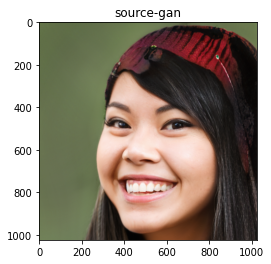

Generating image for seed 1001 (1/3) ...


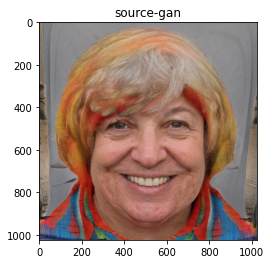

Generating image for seed 1002 (2/3) ...


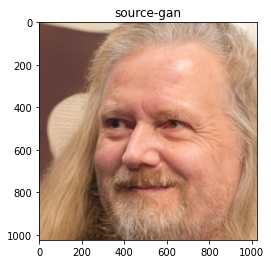

In [4]:
seeds = [1000,1001,1002]
OUTDIR = "/content/seeds"

# Create directory
try:
    os.makedirs(OUTDIR)
except OSError:
    pass

# Generate images.

for seed_idx, seed in enumerate(seeds):
  print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
  lv = seed2vec(G, seed)
  img = render_gan(G, device, lv)
  img.save(f'{OUTDIR}/seed{seed:04d}.png') # Save it
  #display(img2) # Display hi-res
  display_lowres(img)

## Examining the Latent Vector

Below shows the effects of transforming the latent vector between two images. We accomplish this transformation by slowly moving one 512-value latent vector to another 512 vector. A high-dimension point between two latent vectors will appear similar to both of the two endpoint latent vectors. Images that have similar latent vectors will appear similar to each other.

![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [5]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

PKL_NET = "stylegan3-r-ffhq-1024x1024.pkl"

device = torch.device('cuda')
with dnnlib.util.open_url(PKL_NET) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore
    
vector_size = G.z_dim
seeds = expand_seed( [8192+1,8192+9], vector_size)
print(seeds[0].shape)

(1, 512)


In [25]:
# HIDE OUTPUT
# Choose your seeds to morph through and the number of steps to 
# take to get to each.

SEEDS = [6624,6618,6616] # Better for faces
#SEEDS = [1000,1003,1001] # Better for fish
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = render_gan(G, device, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

rm: cannot remove '/content/results/*': No such file or directory


Seed 6618: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [21]:
dir(dnnlib.util)

['Any',
 'EasyDict',
 'List',
 'Logger',
 'Tuple',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dnnlib_cache_dir',
 '_str_to_ctype',
 'ask_yes_no',
 'call_func_by_name',
 'construct_class_by_name',
 'copy_files_and_create_dirs',
 'ctypes',
 'fnmatch',
 'format_time',
 'format_time_brief',
 'get_dtype_and_ctype',
 'get_module_dir_by_obj_name',
 'get_module_from_obj_name',
 'get_obj_by_name',
 'get_obj_from_module',
 'get_top_level_function_name',
 'glob',
 'hashlib',
 'html',
 'importlib',
 'inspect',
 'io',
 'is_pickleable',
 'is_top_level_function',
 'is_url',
 'list_dir_recursively_with_ignore',
 'make_cache_dir_path',
 'np',
 'open_url',
 'os',
 'pickle',
 're',
 'requests',
 'set_cache_dir',
 'shutil',
 'strtobool',
 'sys',
 'tempfile',
 'tuple_product',
 'types',
 'urllib',
 'uuid']